# 機械学習の実装 1 （教師あり学習：回帰）
本章では、重回帰分析のアルゴリズムを用いて、機械学習を実装していきます。  
重回帰分析について理解が不十分な場合は 6 章を参照するようにして下さい。  

流れとしては、前章でも扱った Pandas を用いて機械学習で使用できる形にデータ加工する手順を紹介してから、 重回帰分析を用いてモデルの学習まで行います。その後、モデルの予測性能を改善するための様々な手法を紹介します。  

本章で特に重要な論点として**過学習**という概念があります。機械学習はコンピュータに**大量のデータから法則性を学習させる**ための手法であることは何度かお伝えしてきましたが、学習に使用したデータに対して過剰に適合してしまうと新たな入力データに対して予測性能がうまく発揮できない現象が起きます。  

学習済みモデルが未知のデータに対してどの程度予測がうまく行くのかの性能を**汎化性能**と呼ぶことも覚えておきましょう。  
もし、モデルが未知のデータに対してもうまく予測ができているようであれば汎化性能の高いモデルであると呼ぶことができます。   

## 本章の構成  
- 重回帰分析の実装  
- 線形回帰の過学習を抑制する手法  
- 相関関係と多重共線性問題  

## 重回帰分析の実装

機械学習用のパッケージである scikit-learn を用いての重回帰分析の実装を行いましょう。  

### モジュールのインポート

必要なモジュールをインポートします。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### データセットの準備

まず、scikit-learn の中にあるデータセットを用いて、重回帰分析の実装を行います。  
`sklearn.datasets` モジュール内の `load_boston` メソッドを使用してボストン近郊の住宅データを取り込みます。  

Pandas のデータフレーム型で表示したい方は下記の一連のコードを実行することで作成することができます。  

In [23]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
x = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
t = raw_df.values[1::2, 2]
columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']

scikit-learn に用意されているデータセットは NumPy 形式で保存されています。

In [9]:
x.shape, t.shape

((506, 13), (506,))

NumPy 形式のデータを Pandas の形式に変換する際には `pd.DataFrame()` を使用します。オプションで列名を指定しています。

In [10]:
df = pd.DataFrame(x, columns=columns)
df.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03


データフレームに先程読み込んだ目標値が格納されている変数 `t` を Target という名前で追加します。

In [11]:
df['Target'] = t
df.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


それぞれの列ごとの数値の説明は下記です。今回の実装において重要ではありませんが、気になる方はチェックしてください。

| 列名    | 説明                                                    |
| ------- | ------------------------------------------------------- |
| CRIM    | 人口 1 人当たりの犯罪発生数                             |
| ZN      | 25,000 平方フィート以上の住居区画の占める割合           |
| INDUS   | 小売業以外の商業が占める面積の割合                      |
| CHAS    | チャールズ川によるダミー変数 (1: 川の周辺, 0: それ以外) |
| NOX     | NOx の濃度                                              |
| RM      | 住居の平均部屋数                                        |
| AGE     | 1940 年より前に建てられた物件の割合                     |
| DIS     | 5 つのボストン市の雇用施設からの距離 (重み付け済)       |
| RAD     | 環状高速道路へのアクセスしやすさ                        |
| TAX     | $10,000 ドルあたりの不動産税率の総計                    |
| PTRATIO | 町毎の児童と教師の比率                                  |
| B       | 町毎の黒人 (Bk) の比率を次の式で表したもの。            |
| LSTAT   | 給与の低い職業に従事する人口の割合 (%)                  |

scikit-learn を用いて機械学習アルゴリズムを実装を行う際には NumPy 形式に変換する必要があります。  
Pandas 形式から NumPy 形式に変換する際には `.values` の属性から取得することができます。  

また、同時にデータフレーム内の入力変数と目標値の切り分けも行います。  
データフレーム内の `Target` が目標値に該当し、それ以外が入力変数に該当します。`.iloc` メソッドを使用して、入力変数と目標値の切り分けを行います。

In [12]:
# 入力変数と目標値の切り分け
x = df.iloc[:, :-1].values  # 物件の情報
t = df.iloc[:, -1].values  # 家賃

### 学習用データセットとテスト用データセットへ分割

ここで、まずこのデータセットを 2 つに分割します。 それは、モデルの学習に用いるためのデータと、学習後のモデルのパフォーマンスをテストするために用いるデータは、異なるものになっている必要があるためです。 これは、冒頭で少し触れた汎化性能というものに関わる重要なことです。  

ここで、例え話を使ってなぜデータセットを分割する必要があるかを説明します。 例えば、大学受験の準備のために 10 年分の過去問を購入し、一部を勉強のために、一部を勉強の成果をはかるために使用したいとします。 10 年分という限られた数の問題を使って、結果にある程度の信頼のおけるような方法で実力をチェックするには、下記の 2 つのうちどちらの方法がより良いでしょうか。

- 10 年分の過去問全てを使って勉強したあと、もう一度同じ問題を使って実力をはかる
- 5 年分の過去問だけを使って勉強し、残りの 5 年分の未だ見たことがない問題を使って実力をはかる

一度勉強した問題を再び解くことができると確認できても、大学受験の当日に未知の問題が出たときにどの程度対処できるかを事前にチェックするには不十分です。 よって、後者のような方法で数限られた問題を活用する方が、本当の実力をはかるには有効でしょう。

これは機械学習におけるモデルの学習と検証でも同様に言えることです。 実力をつけるための勉強に使うデータの集まりを、**学習用データセット (training dataset)** といい、実力をはかるために使うデータの集まりを、**テスト用データセット (test dataset)** と言います。 このとき、学習用データセットとテスト用データセットに含まれるデータの間には、重複がないようにします。

早速、さきほど用意した `x` と `t` を、学習用データセットとテスト用データセットに分割しましょう。 どのように分けるかには色々な方法がありますが、単純に全体の何割かを学習用データセットとし、残りをテスト用データセットとする、といった分割を行う方法は**ホールドアウト法 (holdout method)** と呼ばれます。 scikit-learn では、データセットから指定された割合（もしくは個数）のデータをランダムに抽出して学習用データセットを作成し、残りをテスト用データセットとする処理を行う関数が提供されています。

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.3, random_state=0)

ここで、`train_test_split()` の `test_size` という引数に `0.3` を与えています。 これはテスト用データセットを全体の 30% のデータを用いて作成することを意味しています。 自動的に残りの 70% は学習用データセットとなります。 上のコードは全サンプルの中からランダムに 70% を学習用データセットとして抽出し、残った 30% をテスト用データセットとして返します。

例えば、データセット中のサンプルが、目標値が 1 のサンプルが 10 個、2 のサンプルが 8 個、3 のサンプルが 12個…というように、カテゴリごとにまとめられて並んでいることがあります。 そのとき、データセットの先頭から 18 個目のところで学習用データセットとテスト用データセットに分割したとすると、学習用データセットには目標値が 3 のデータが 1 つも含まれないこととなります。

そこで、ランダムにデータセットを分割する方法が採用されています。 `random_state` という引数に毎回同じ整数を与えることで、実行のたびに結果が変わることを防いでいます。

それでは、分割後の学習用データセットを用いてモデルの学習、精度の検証を行いましょう。

### モデルの学習・検証

scikit-learn を用いて学習を行う際には基本的には下記のステップに沿って実装を行います。  

- Step 1 : モデルの定義
- Step 2 : モデルの学習
- Step 3 : モデルの検証

早速実装を行いましょう。  

**Step 1 : モデルの定義**

モデルの定義ではどの機械学習アルゴリズムを使用してモデルの構築を行うのかを定義します。  
scikit-learn で重回帰分析を行う場合は、`LinearRegression` クラスを使用します。 `sklearn.linear_model` 以下にある `LinearRegression` クラスを読み込んで、インスタンスを作成しましょう。

In [15]:
# Step 1 : モデルの定義
from sklearn.linear_model import LinearRegression
model = LinearRegression()

上記のコードは、第 6 章で紹介した「モデルを決める」、「目的関数を決める」までを行っています。  
`LinearRegression` は重回帰分析を行うクラスで、目的関数や最適化手法もあらかじめ内部で用意されたものが使用されます。 詳しくはこちらのドキュメントを参照してください。 参考：[sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

**Step 2 : モデルの学習**

次にモデルの学習を行います。 scikit-learn に用意されている手法の多くは、共通して `fit()` というメソッドを持っており、 再利用可能なコードが書きやすくなっています。

`model` を用いて学習を実行するには、`fit()` の引数に入力値 `x` と目標値 `t` を与えます。今回学習に使用するデータセットは先程切り分けを行った、学習用のデータセットになります。

In [16]:
# モデルの学習
model.fit(x_train, t_train)

LinearRegression()

**Step 3 : モデルの検証**  

モデルの学習が完了しました。求まったパラメータの値を確認してみましょう。重回帰分析では、重み `w` とバイアス `b` の ２ つがパラメータでした。求まった重み `w` の値は `model.coef_` 属性に、バイアス `b` の値は `model.intercept_` 属性に格納されています。

In [17]:
# 学習後のパラメータ w
model.coef_

array([-1.21310401e-01,  4.44664254e-02,  1.13416945e-02,  2.51124642e+00,
       -1.62312529e+01,  3.85906801e+00, -9.98516565e-03, -1.50026956e+00,
        2.42143466e-01, -1.10716124e-02, -1.01775264e+00,  6.81446545e-03,
       -4.86738066e-01])

<BarContainer object of 13 artists>

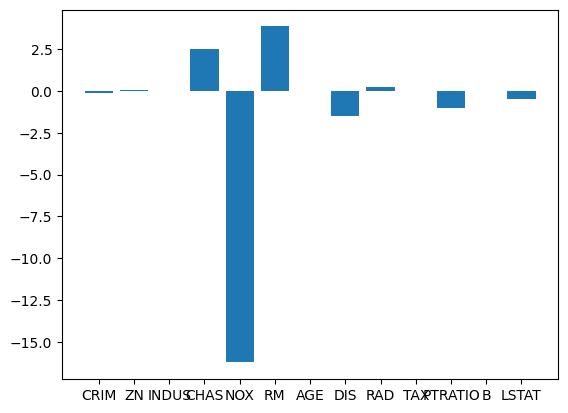

In [18]:
# パラメータの分布をヒストグラムで可視化
plt.bar(x=columns, height=model.coef_)

In [19]:
# 学習後のバイアス b
model.intercept_

37.93710774183308

モデルの学習が完了したら、精度の検証を行います。 `LinearRegression` クラスは `score()` メソッドを提供しており、入力値と目標値を与えると学習済みのモデルを用いて計算した**決定係数 (coefficient of determination)** という指標を返します。

これは、使用するデータセットのサンプルサイズを `N`、`n` 個目の入力値に対する予測値を `yn`、目標値を `tn`、そしてそのデータセット内の全ての目標値の平均値を `t¯` としたとき、

$$
R^{2} = 1 - \dfrac{\sum_{n=1}^{N}\left( t_{n} - y_{n} \right)^{2}}{\sum_{n=1}^{N}\left( t_{n} - \bar{t} \right)^{2}}
$$

で表される指標です。

決定係数の最大値は 1 であり、値が大きいほどモデルが与えられたデータに当てはまっていることを表します。

In [20]:
# モデルの検証
print('train : ', model.score(x_train, t_train))
print('test : ', model.score(x_test, t_test))

train :  0.7645451026942548
test :  0.6733825506400171


学習済みモデルを用いて学習用データセットで計算した決定係数は、およそ 0.765 でした。  
テスト用データセットは およそ 0.673 と学習用データセットに対しての決定係数よりも値が小さくなりました。  

教師あり学習の目的は、学習時には見たことがない新しいデータ、ここではテスト用データセットに含まれているデータに対しても、高い性能を発揮するように、モデルを学習することです。 逆に、上記の例のように学習時に用いたデータに対してはよく当てはまっていても、学習時に用いなかったデータに対しては予測値と目標値の差異が大きくなってしまう現象を、**過学習 (overfitting)** と言います。

### 新しい入力値に対する予測値の計算（推論）

学習が終わったモデルに、新たな入力値を与えて、予測値を計算させるには、`predict()` メソッドを用います。 学習済みのモデルを使ったこのような計算は、**推論 (inference)** と呼ばれることがあります。 今回は、学習済みモデル `model` を用いて、テスト用データセットからサンプルを 1 つ取り出し、推論を行ってみましょう。 このとき、`predict()` メソッドに与える入力値の `ndarray` の形が (サンプルサイズ, 各サンプルの次元数) となっている必要があることに気をつけてください。

In [21]:
# 推論
y = model.predict(x_test)

In [22]:
print('推論結果：',y[0])
print('教師データ：', t_test[0])

推論結果： 24.935707898576915
教師データ： 22.6


## 線形回帰の過学習を抑制する手法

前述した過学習を防ぐために、様々な方法があります。代表的な方法は下記になります。  

- データセットのサンプル数を増やす  
- ハイパーパラメータを調整する  
- 他のアルゴリズムを使用する  

データセットのサンプル数を増やすについては、講義の範囲で扱えるデータセットのサンプル数に限りがあるため実施できないのですが、知識として重要なので覚えておきましょう。また、ハイパーパラメータの調整については 14 章で詳しく紹介します。  

本章では、重回帰分析以外のアルゴリズムを用いて過学習を抑制できるか確認します。  
どのアルゴリズムが適切かを検証するためには手法を実装し、精度を比較する方法が最も簡単です。今回は下記に挙げる 2 つのアルゴリズムを実装します。  

- Ridge 回帰（リッジ回帰）
- Lasso 回帰（ラッソ回帰）

### Ridge 回帰

過学習を抑制するための手法でよく用いられるものの 1 つに**正則化 (regularization)** があります。  
機械学習において、正則化は損失関数に**正則化項**と呼ばれるモデルの複雑性に罰則（ペナルティ）を科すために追加の項を導入する手法を指します。  

Ridge 回帰は重回帰分析に対して重みの 2 乗 ${{||w||_2}^2}$ で表現される ${\ell _{2}}$ ノルムを用いて正則化を行うことで、モデルの過度な複雑さに罰則を課して過学習を抑制する手法です。  

数式で表現すると、損失関数 ${L}$ が下記の様に変化します。  

$$
{{L}} = {{|| {\textbf X} {\textbf w} - {\textbf t}||_2}^2 + \alpha {||{\textbf w}||_2}^2}
$$

重回帰分析と比較すると第 2 項に正則化項と呼ばれる ${{\alpha||w||_2}^2}$ が増えています。この $\alpha$ の値が罰則の強さで、この値を大きくするほど小さな幅でパラメータが調整されます。
機械学習のモデルは学習によってパラメータの値を算出もしくは調整を行います。それに対し、この $\alpha$ のようにモデルの学習を実行する前に設定する値を**ハイパーパラメータ**と呼びます。

※ノルムの詳細については[こちら](https://ja.wikipedia.org/wiki/%E3%83%8E%E3%83%AB%E3%83%A0)、正則化の詳細については[こちら](https://ja.wikipedia.org/wiki/%E6%AD%A3%E5%89%87%E5%8C%96)を参照してください。  


全体の手順は先ほどの重回帰分析と同じ流れでなので、実装を進めて行きましょう。  

In [ ]:
# モデルの定義、ハイパーパラメータの値を設定
from sklearn.linear_model import Ridge
model = Ridge(alpha=1)

In [ ]:
# モデルの学習
model.fit(x_train, t_train)

In [ ]:
# モデルの検証
print('train : ', model.score(x_train, t_train))
print('test : ', model.score(x_test, t_test))

先ほどの「train : 0.765, test : 0.673」からほとんど差が無いので、今回のデータセットにおいて Ridge 回帰はあまり有効でない様です。    
調整後のパラメータを確認して、どのような変化があるのか確認しておきましょう。

In [ ]:
model.coef_

In [ ]:
plt.bar(x=columns, height=model.coef_)

重回帰分析の学習済みモデルの最も大きかったパラメータと今回の最も大きいパラメータの値を比較すると今回の方が値が小さくなっていることが確認できます。  
正則化が適用され、パラメータの調整範囲が限定されていることが確認できます。  
正則化項の $\alpha$ の値を調整することによって、パラメータが調整される幅にどのように変化があるか確認してみましょう。  

Ridge 回帰を用いて今回は予測精度の改善は見られませんでしたが、1 つの選択肢として、覚えておきましょう。

### Lasso 回帰
Lasso 回帰は重回帰分析に対して、 ${||w||_1}$ で表現される ${\ell _{1}}$ ノルムを使用して正則化を行う手法です。  

先ほどの Ridge 回帰と同じく重回帰分析で用いた損失関数に正則化項（第 2 項）を加えてペナルティを課しますが、 ${\ell _{1}}$  を使用する点が異なります。  

$$
{{L}} = {||{\textbf X} {\textbf w} - {\textbf t}||_2 ^ 2 + \alpha ||{\textbf w}||_1}
$$


Lasso 回帰の特徴として、不要な入力変数を特定し、該当する重み $w$ を $0$ にする事で実質的に入力変数の種類を減らすことが出来る点あります。このとき生成される 重みベクトル ${\textbf w}$ は $0$ を多く含み、これを**スパース性**のある行列だと表現します。  

入力変数を減らすことができる特徴から、高次元の入力変数に対して高い効果を発揮する場合があります。  

Lasso 回帰も今までと同様に scikit-learn で簡単に実装が可能です。  

In [ ]:
 # モデルの定義
from sklearn.linear_model import Lasso
model = Lasso(alpha=1)

In [ ]:
# モデルの学習
model.fit(x_train, t_train)

In [ ]:
# モデルの検証
print('train : ', model.score(x_train, t_train))
print('test : ', model.score(x_test, t_test))

Lasso 回帰の結果も Ridge 回帰の結果と同様あまり予測精度は向上は見られませんでした。  
しかし、データセットによってはこれらのアルゴリズムが有効なケースもあることを抑えておきましょう。  

In [ ]:
model.coef_

In [ ]:
plt.bar(x=columns, height=model.coef_)

更新後のパラメータを確認すると、いくつかの入力変数に紐づく重み $w$ が 0 になっています。  
冒頭にお伝えした Lasso 回帰の特長によって不要な入力変数を減らすことが出来ています。  

## 相関関係と多重共線性問題

重回帰分析を使用しているとよく直面する問題として、**多重共線性**と呼ばれる問題があります。  
その問題の確認と、対処法を確認しましょう。  

### データセットの準備

こちらから [regression_pls.csv](http://drive.google.com/uc?export=view&id=103ur3ZU7LwO3hLZfEOIi_srxs8I40WQD) をダウンロードします。

データセットを Colab へアップロードして、データの中身を確認します。  
Colab へのファイルのアップロードは GUI でも行うことが可能ですが、下記のコードを実行し、「ファイル選択」をクリックしても可能なことも覚えておきましょう。

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
df = pd.read_csv('regression_pls.csv')
df.head(2)

In [ ]:
df.shape

入力変数 `x` と目標値 `t` に切り分けを行います。  
今回は目標値は Target の列が該当し、その他の列が入力変数に該当します。

In [ ]:
# データの切り分け→Numpy形式に変換
x = df.iloc[:, 1:].values
t = df.iloc[:, 0].values
print(x.shape, t.shape)

今回は入力変数の数が 196 個と先ほどと比べて大幅に数が増えていることが確認できます。  

### 練習問題 重回帰分析の実装

重回帰分析の実装方法復習しましょう。下記の内容を次のセルに記述し、実行結果を確認してください。（必要に応じてセルの追加を行ってください。）  

- 学習用データセットとテスト用データセットの分割（テスト用データセットの割合 : 30% 、random_state : 0）
- 重回帰分析の実装（モデルの定義、モデルの学習、モデルの検証）

*ヒント*  
モデルの学習は学習用データセットで行い、モデルの検証は学習用データセットとテスト用データセットの両方で行いましょう。  

In [ ]:
# 学習用データセットとテスト用データセットの分割（テスト用データセットの割合 : 30% 、random_state : 0）


In [ ]:
# データセットのサイズの確認


In [ ]:
# モデルの定義（重回帰分析）


In [ ]:
# モデルの学習


In [ ]:
# モデルの検証


#### 模範解答

In [ ]:
# 学習用データセットとテスト用データセットの分割（テスト用データセットの割合 : 30% 、random_state : 0）
from sklearn.model_selection import train_test_split
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.3, random_state=0)

In [ ]:
# データセットのサイズの確認
print('学習用データセット :', x_train.shape, t_train.shape)
print('テスト用データセット :', x_test.shape, t_test.shape)

In [ ]:
# モデルの定義（重回帰分析）
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [ ]:
# モデルの学習
model.fit(x_train, t_train)

In [ ]:
# モデルの検証
print('train : ', model.score(x_train, t_train))
print('test : ', model.score(x_test, t_test))

テスト用データセットに対しての決定係数の値が大幅に低くなっています。  
このような学習用データセットに対しての予測精度が高く、テスト用データセットの予測精度が低い状態を **過学習 (Over fitting)** と呼びました。  

過学習がおこる原因は様々ですが、今回は入力変数同士の相関が強いものが含まれているため、 **[多重共線性（ Multicollinearity ）](https://ja.wikipedia.org/wiki/%E9%87%8D%E5%9B%9E%E5%B8%B0%E5%88%86%E6%9E%90#%E5%A4%9A%E9%87%8D%E5%85%B1%E7%B7%9A%E6%80%A7)** という問題が起こっているためです。詳細の説明は割愛しますが、一般的に機械学習アルゴリズムは学習時に相関の高い入力変数を使用することにより、モデルの予測精度向上の妨げとなる場合が多いです。その対策としては単純にデータセットの中から相関の高い入力変数のどちらかを削除する方法や使用するアルゴリズムを変更するなどが挙げられます。    

### 相関関係の確認

多重共線性の問題に取り組む前に、実際に入力変数同士の相関が高いのか確認してみましょう。  
`.corr()`を使用して相関関係を表す数値（相関係数）を確認することができます。（デフォルトではピアソンの相関を使用して値が算出されています。）

相関係数は 1 が最大で、その 2 つの変数が完全に相関していることを表しています。例えば変数 a と変数 b の相関係数が 1 の場合は変数 a が 1 増えると変数 b も 1 増えるというような関係になります。

In [ ]:
df_corr = df.corr()
df_corr.head(3)

今回はヒートマップ（数値の大小を色の違いで表現する可視化方法）を用いて、可視化を行います。  
可視化には seaborn というパッケージを使用します。seaborn は Python の可視化用のパッケージで、 Matplotlib をベースに作成されています。Matplotlib と比較してより高度な可視化を行うことが可能です。  
seaborn を用いてヒートマップを使用する際には、`seaborn.heatmap()` のメソッドを使用します。引数のオプションで `annot=True` とすることにより、ヒートマップ中に数値を表示することができます。seaborn の読み込みの際は慣習的に `as sns` として読み込むことが多いです。

今回はサンプル数・入力変数の数の両方が多いため、データセットの最初の 30 行、30 列を使用します。  
また、ノートブック上で表示するプロットのサイズを調整するために `matplotlib.pyplot.figure()` のメソッドを使用しています。

In [ ]:
import seaborn as sns
plt.figure(figsize=(22, 8))
sns.heatmap(df_corr.iloc[:30, :30], annot=True)

相関関係が高い部分が直感的にわかるように可視化することができました。  
入力変数同士の相関が高い部分があることが確認できます。例えば `x1` と `x16` は相関係数が 0.92 となっており、相関が高いことが確認できます。

入力変数同士個別の相関関係を可視化するには `sns.jointplot(列名1, 列名2, データフレーム)` で可能です。

In [ ]:
sns.jointplot('x1', 'x16', df)

ヒートマップで確認した相関が高いところを描画すると、線形で表現できるほど相関が高いことが確認できました。  

今回重回帰分析を実装し、その予測精度が低かった原因として、この入力変数同士の相関が高い多重共線性の問題が起こっている可能性が高いと言えます。  
単純に相関の高い入力変数を取り除くアプローチも考えられますが、今回は PLS (Partial Least Squares regression)と呼ばれる手法を用いてこの問題を解決できるか確認してみます。  

### PLS（ Partial Least Squares regression ）

PLS とは 2 つの手法を組み合わせたアルゴリズムで、下記のステップで実装されています。（注釈 1）


- 入力値に対して主成分分析と呼ばれる次元削減を行う
- 次元削減後のデータで重回帰分析を用いてモデルの学習を行う

scikit-learn に用意されているモジュール `PLSRegression` を使用するとこれらのステップを意識せずに実装できますが、裏側の挙動として理解しておきましょう。

また、主成分分析とは、例えば 100 個の入力変数があった場合にその入力変数を 10 や 20 個などに削減する手法（次元削減）になります。  
詳細に関しては 15 章で解説します。  

（*注釈 1 : 厳密に PLS 学習のステップで紹介した流れとは少し異なる部分があります。本資料では厳密性よりわかりやすさを優先するため、上記のような解説を用いています。厳密な定義に関しては[こちら](https://en.wikipedia.org/wiki/Partial_least_squares_regression)を参照してください。*）

In [ ]:
 # モデルの定義
from sklearn.cross_decomposition import PLSRegression
model = PLSRegression(n_components=7)

In [ ]:
# モデルの学習
model.fit(x_train, t_train)

In [ ]:
# モデルの検証
print('train : ', model.score(x_train, t_train))
print('test : ', model.score(x_test, t_test))

決定係数の値が大幅に改善していることが確認することができます。  
PLS を使用する事で多重共線性の問題を解消できることがわかりました。  

このように、scikit-learn を用いると様々な機械学習アルゴリズムを簡単に実装できます。細かい理論も重要ですが、まずはそれぞれのアルゴリズムの特徴を捉え、どのような場面で活用できるのかといった点を抑えることを意識して学習を進めましょう。  

## 練習問題 本章のまとめ
本章で学んだ内容を復習しましょう。下記の内容を次のセルに記述し、実行結果を確認してください。（必要に応じてセルの追加を行ってください。）  
下記の内容に従い、回帰のアルゴリズムの実装を行ってください。（使用する手法は問いません。）

- こちらの [regression_excersize.csv](http://drive.google.com/uc?export=view&id=1r3nb0sgt1OpYmn-y1PSWWntPudBtjmRX) をダウンロードし、Colab にアップロード
- アップロードした CSV ファイルの読み込みとデータセットの確認
- 目標値 `Target` を変数 `t` に格納、それ以外を入力変数 `x` とし、変数に格納
- 学習用データセットとテスト用データセットの分割（テスト用データセットの割合 : 30% 、random_state : 0）
- 回帰アルゴリズムの実装（モデルの定義、モデルの学習、モデルの検証）

*ヒント*  
まずは重回帰分析を用いて実装し、その他のアルゴリズムでどのように予測精度が変化するか確認しましょう。

In [ ]:
# ファイルのアップロード
from google.colab import files
uploaded = files.upload()

In [ ]:
# データセットの読み込み


In [ ]:
# 目標値と入力変数の分割　→　NumPy形式に変換


In [ ]:
# 学習用データセットとテスト用データセットの分割（テストデータの割合 : 30% 、random_state : 0 ）


In [ ]:
# モデルの定義


In [ ]:
# モデルの学習


In [ ]:
# モデルの検証（学習用データセットとテスト用データセット）



<img src="http://drive.google.com/uc?export=view&id=1g2xjXbw5qYeqdJqcOf3uASvzBQxhlE8u" width=30%>